# Using unsupervised and supervised machine learning to discover discrepancies between the two counter-circulating beams of the Large Hadron Collider

4 kinds of analysis (k-means clustering, Euclidean distance, DBSCAN, Linear classifier) x 2 kinds of data (PCA, not PCA) x 4 beam modes (flat_top, start_ramp, start_adjust, start_squeeze)

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker # for spacing out Fill number labels on x-axis
import pandas as pd
import math
import statistics
from sklearn.cluster import KMeans

#TODO document each function.  see data collection notebook for how to do that

## Load data


This data must be available before running this notebook.  Run the `Data collection.ipynb` notebook to create the data if it does not exist.

In [2]:
# Read saved ('pickled') DataFrames (result of Data collection notebook)
startRampLosses = pd.read_pickle("data/pickles/startRampLosses.pkl")
startAdjustLosses = pd.read_pickle("data/pickles/startAdjustLosses.pkl")
startSqueezeLosses = pd.read_pickle("data/pickles/startSqueezeLosses.pkl")
flatTopLosses = pd.read_pickle("data/pickles/flatTopLosses.pkl")

startRampTimestamps = startRampLosses['timestamp']
startAdjustTimestamps = startAdjustLosses['timestamp']
startSqueezeTimestamps = startSqueezeLosses['timestamp']
flatTopTimestamps = flatTopLosses['timestamp']

startRampLosses.drop(columns='timestamp', inplace=True)
startAdjustLosses.drop(columns='timestamp', inplace=True)
startSqueezeLosses.drop(columns='timestamp', inplace=True)
flatTopLosses.drop(columns='timestamp', inplace=True)

# lossesDfs = {
#     'start_ramp': pd.read_pickle("data/pickles/startRampLosses.pkl"),
#     'start_adjust': pd.read_pickle("data/pickles/startAdjustLosses.pkl"),
#     'start_squeeze': pd.read_pickle("data/pickles/startSqueezeLosses.pkl"),
#     'flat_top': pd.read_pickle("data/pickles/flatTopLosses.pkl")
# }

# OR
# lossesDfs = {
#     'start_adjust': (startAdjustLosses, startAdjustLossesPCA),
#     'flat_top': (flatTopLosses, flatTopLossesPCA),
#      ...
# }
# accessed: lossesDf['start_adjust'][0]
#           lossesDf['start_adjust'][1]
# or to iterate through:
# for name, df in dfs.items():
#

#TODO - maybe have just one losses variable, and read_pickle the different loss files manually (parameterising the notebook)

## Preprocessing

### Check variances, range

In [3]:
losses = flatTopLosses  # change to any one of the other losses to compare (startRampLosses, startAdjustLosses, ...)

print("Std deviation\n")
print(f'Lowest: {losses.std().sort_values().head(1)}')
print(f'Highest: {losses.std().sort_values().tail(1)}')
print("\nRange\n")
print(f'Lowest: {(losses.max() - losses.min()).sort_values().head(1)}')
print(f'Highest: {(losses.max() - losses.min()).sort_values().tail(1)}')

Std deviation

Lowest: TCL.6x1    1.225111e-07
dtype: float64
Highest: TCLA.A6x7    0.158534
dtype: float64

Range

Lowest: TCL.6x1    7.043000e-07
dtype: float64
Highest: TCLA.A6x7    0.566399
dtype: float64


There is a large difference in order of magnitude in variance and range between the BLMs.  So that BLMs with high variance do not dominate the clustering and PCA calculations, we must standardise the values.

### Standardise data

According to https://maxwellsci.com/msproof.php?doi=rjaset.6.3638 standardisation is the most effective scaling technique before k-means.

TODO explain that Standardising is not just useful for k-means but also DBSCAN

TODO explain also that standardising is best before PCA (isn't it?) (as opposed to min-max etc.)

TODO compare clustering efficiency with robustscaler, min-max scaler

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

startRampLosses.loc[:] = scaler.fit_transform(startRampLosses.loc[:])
startSqueezeLosses.loc[:] = scaler.fit_transform(startSqueezeLosses.loc[:])
startAdjustLosses.loc[:] = scaler.fit_transform(startAdjustLosses.loc[:])
flatTopLosses.loc[:] = scaler.fit_transform(flatTopLosses.loc[:])

### Dimensionality reduction using PCA

In [5]:
from sklearn.decomposition import PCA

# pca = PCA()  # n_components not set => keep all components
# TODO print the explained variance ratio?  is it useful for the report?
# print('Explained variance ratio of each BLM (sums to 1):')
# pca.fit(startRampLosses)
# print(pca.explained_variance_ratio_)
# print(sum(pca.explained_variance_ratio_))

pca = PCA(n_components=3, whiten=True)
# From https://scikit-learn.org/stable/modules/decomposition.html#pca
# The optional parameter whiten=True makes it possible to project the data onto the singular space while scaling each 
# component to unit variance. This is often useful if the models down-stream make strong assumptions on the isotropy 
# of the signal: this is for example the case for Support Vector Machines with the RBF kernel and the K-Means clustering 
# algorithm.
# I am using k-means clustering, and also DBSCAN, but not using the RBF kernel - using linear kernel for SVM.
# but I think this is also using Euclidean distance (to get best fit line / hyperplane) and therefore I think it is also
# assuming isotropy.
# TODO ask what "project the data onto the singular space" means.  and ask if agreed that whiten=True should be used.  
startRampLossesPCA = pd.DataFrame(data=pca.fit_transform(startRampLosses), index=startRampLosses.index, columns=['PCA1', 'PCA2', 'PCA3'])
startSqueezeLossesPCA = pd.DataFrame(data=pca.fit_transform(startSqueezeLosses), index=startSqueezeLosses.index, columns=['PCA1', 'PCA2', 'PCA3'])
startAdjustLossesPCA = pd.DataFrame(data=pca.fit_transform(startAdjustLosses), index=startAdjustLosses.index, columns=['PCA1', 'PCA2', 'PCA3'])
flatTopLossesPCA = pd.DataFrame(data=pca.fit_transform(flatTopLosses), index=flatTopLosses.index, columns=['PCA1', 'PCA2', 'PCA3'])

Using PCA parameter `whiten=True`, we get unit variance.  This is useful for clustering algorithms (k-means, DBSCAN) that assume the signal is isotropic in all directions.

In [6]:
flatTopLossesPCA.std()

PCA1    1.0
PCA2    1.0
PCA3    1.0
dtype: float64

## Visualising the 3D PCA data

Helper function

In [7]:
def scatterPlotLosses(losses, title="", ax=None):
    noExistingAxes = (ax == None)

    if noExistingAxes:
        from mpl_toolkits.mplot3d import Axes3D
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    
    xs = losses.loc['B1'][losses.columns[0]]
    ys = losses.loc['B1'][losses.columns[1]]
    zs = losses.loc['B1'][losses.columns[2]]
    ax.scatter(xs, ys, zs, c='red', label='B1')

    xs = losses.loc['B2'][losses.columns[0]]
    ys = losses.loc['B2'][losses.columns[1]]
    zs = losses.loc['B2'][losses.columns[2]]
    ax.scatter(xs, ys, zs, c='black', label='B2')

    ax.set_title(title)
    ax.set_xlabel(losses.columns[0])
    ax.set_ylabel(losses.columns[1])
    ax.set_zlabel(losses.columns[2])
    ax.add_artist(ax.legend(framealpha=0.5, loc="lower left"))
    
    if noExistingAxes:
        plt.show()

Plotting

<IPython.core.display.Javascript object>


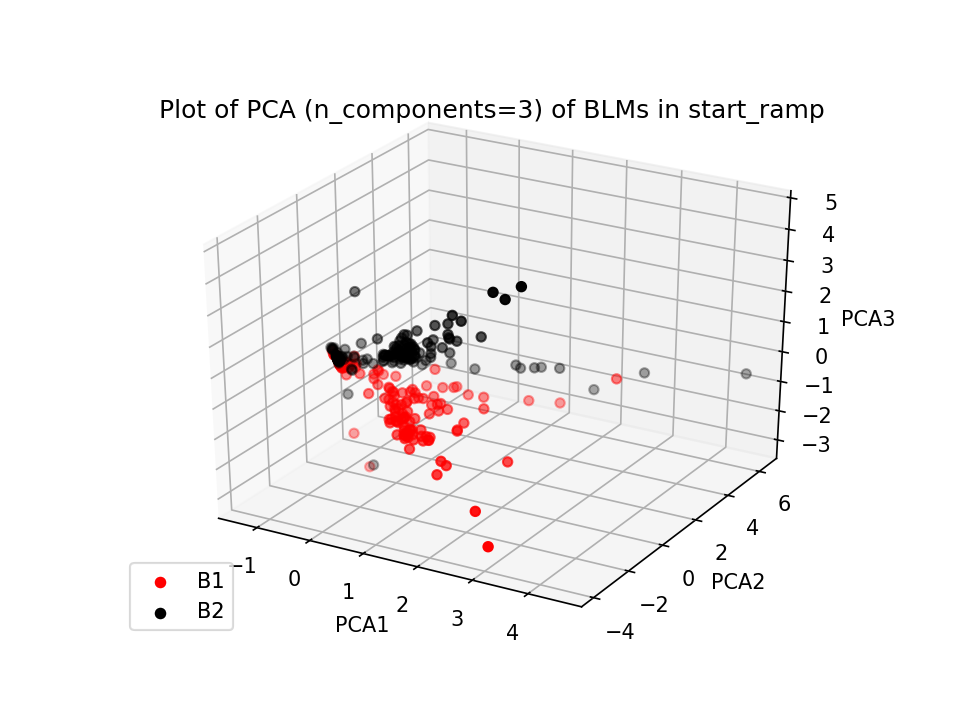

In [8]:
scatterPlotLosses(startRampLossesPCA, "Plot of PCA (n_components=3) of BLMs in start_ramp")

<IPython.core.display.Javascript object>


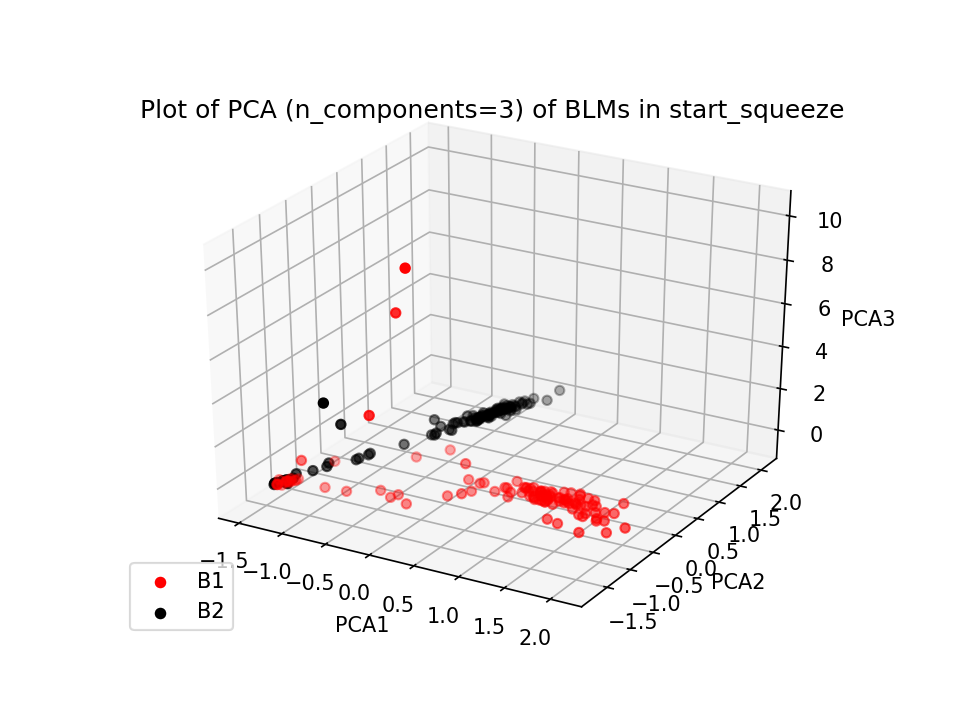

In [9]:
scatterPlotLosses(startSqueezeLossesPCA, "Plot of PCA (n_components=3) of BLMs in start_squeeze")

<IPython.core.display.Javascript object>


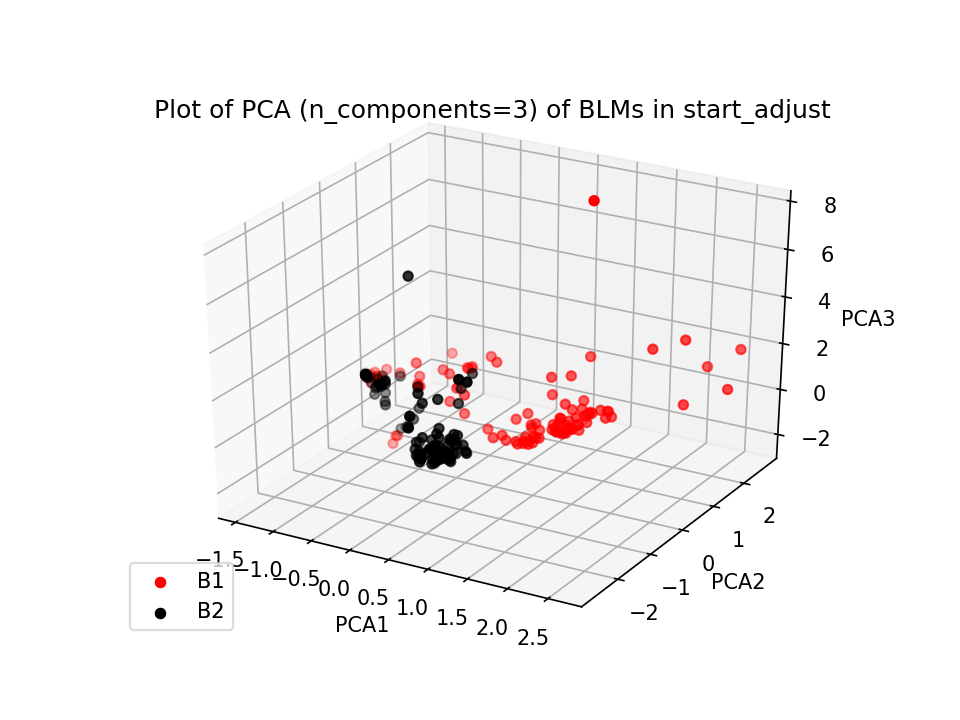

In [10]:
scatterPlotLosses(startAdjustLossesPCA, "Plot of PCA (n_components=3) of BLMs in start_adjust")

<IPython.core.display.Javascript object>


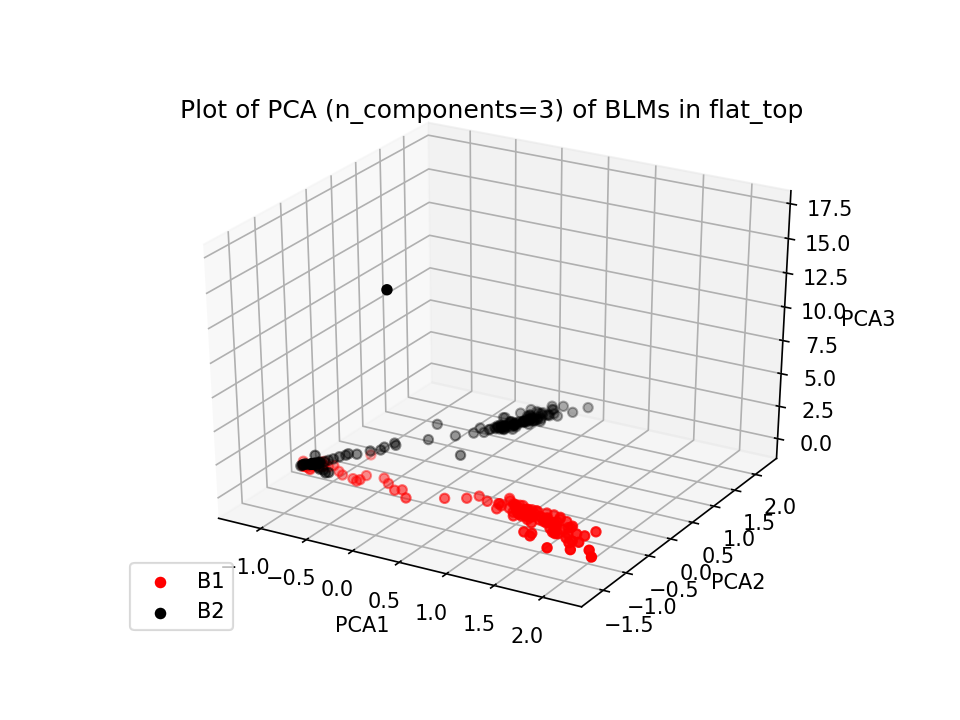

In [11]:
scatterPlotLosses(flatTopLossesPCA, "Plot of PCA (n_components=3) of BLMs in flat_top")

## Clustering classes and functions

In [12]:
class Cluster:
    """Used to hold information about a particular cluster
    
    Attributes
    ----------
    clusterNo : int
        See __init__ parameter
    trainingSamplesCount : int
        number of samples (i.e. losses) used to perform the clustering
    b1Count : int
        number of beam 1 losses in the cluster
    b2Count : int
        number of beam 2 losses in the cluster
    size : int
        size of the cluster, i.e. number of losses in the cluster
    b1Proportion : float
        The proportion of beam 1 losses in the cluster i.e. b1Count / size
    b2Proportion : float
        The proportion of beam 2 losses in the cluster i.e. b2Count / size
    accuracy : float
        The maximum out of b1Proportion and b2Proportion - whichever is highest dictates which class the cluster represents
        (B1 or B2).  eg. if the cluster has b1Proportion > b2Proportion, then beam 2 points in this cluster are errors.
    """
    def __init__(self, clusterNo, labels):
        """Determines the size of the cluster, the count and proportion of B1 and B2 losses, and the accuracy.
        
        Parameters
        ----------
        clusterNo : int
            Cluster label, taken from the labels list returned by the scikit-learn clustering method
        labels : list of int
            Cluster labels returned by the scikit-learn clustering method.  There should be an element (i.e. a label)
            for every training sample.
        """
        
        self.clusterNo = clusterNo
        self.trainingSamplesCount = len(labels)
        
        # split labels into two halves - the first half corresponds to B1 losses, the second half to B2 losses
        # (this is how the losses DataFrames are organised)
        assert len(labels) % 2 == 0
        b1Labels = list(labels[: len(labels)//2])
        b2Labels = list(labels[len(labels)//2 :])
        
        # count number of times this clusterNo appears in the B1, B2 part of labels
        self.b1Count = b1Labels.count(clusterNo)
        self.b2Count = b2Labels.count(clusterNo)
        self.size = self.b1Count + self.b2Count
        
        self.b1Proportion = self.b1Count / self.size
        self.b2Proportion = self.b2Count / self.size
        self.accuracy = max(self.b1Proportion, self.b2Proportion)
        
    def describe(self):
        """Prints the cluster number, size, and beam 1, beam 2 proportions."""
        # TODO: should also print accuracy?
        
        print(f'\tCluster {self.clusterNo} has {(self.size / self.trainingSamplesCount):.2%} of the losses, of which:')
        print(f'\t\t\t{self.b1Proportion:.2%} are B1, \t{self.b2Proportion:.2%} are B2\n')

In [13]:
class ClusteringResult:
    """Used to hold information about a clustering result (i.e. the labels returned by eg. KMeans, DBSCAN)
    
    Attributes
    ----------
    labels : list of int
        See __init__ parameter
    clusters : dict of Cluster objects
        key is cluster number (taken from labels), value is the corresponding Cluster object
    averageAccuracy : float
        The average of the clusters' accuracies
    """
    def __init__(self, labels):
        """Instantiates Cluster objects for each of the clusters in labels.  Calculates the average accuracy.
        
        Note:  Loops from min cluster label to max cluster label in order to instantiate each Cluster.
        
        Parameters
        ----------
        labels : list of int
            Cluster labels returned by the scikit-learn clustering method.  There should be an element (i.e. a label)
            for every training sample.
        """
        self.labels = labels
        self.clusters = {}
        
        for clusterNo in range(min(labels), max(labels) + 1):  # loop through clusters
            self.clusters[clusterNo] = Cluster(clusterNo, labels)
        
        sizes = list(map(lambda cluster: cluster.size, self.clusters.values()))
        assert sum(sizes) == len(labels) # make sure that every training sample was assigned a cluster
                                     # i.e. that the sum of the sizes of each cluster adds up to the number of training samples
        
        accuracies = list(map(lambda cluster: cluster.accuracy, self.clusters.values()))
        
        self.averageAccuracy = sum(accuracies) / len(accuracies)
        
    def describe(self):
        """Prints the average accuracy, and calls each Cluster's describe() method"""
        
        print(f'\tAverage accuracy = {self.averageAccuracy:.2%}')
        for cluster in self.clusters.values():
            cluster.describe()

In [15]:
def scatterPlotClusters(losses, title="", labels=None):
    from mpl_toolkits.mplot3d import Axes3D
    
    assert len(losses) == len(labels)

    fig = plt.figure(figsize=plt.figaspect(0.5))  # make the figure half as tall as it is wide
    
    # Clusters subplot
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.set_title(title)
    scatter = ax.scatter(losses[losses.columns[0]], losses[losses.columns[1]], losses[losses.columns[2]],
               c=labels)
    ax.set_xlabel(losses.columns[0])
    ax.set_ylabel(losses.columns[1])
    ax.set_zlabel(losses.columns[2])
    
    ax.add_artist(ax.legend(*scatter.legend_elements(), title="Clusters", loc="lower left", framealpha=0.5))
    
    # Ground truth subplot
    scatterPlotLosses(losses, "Ground truth", fig.add_subplot(1, 2, 2, projection='3d'))
    
    plt.show()

## KMeans clustering

### Helper functions

In [16]:
def kmeansAnalysis(kmeans, losses, phaseName, runCount):
    print(f"{phaseName}\n")

    is3D = (len(losses.columns) == 3)
    results = []

    for i in range(0, runCount):
        labels = kmeans.fit_predict(losses)
        results.append(ClusteringResult(labels))
        
    # average accuracy of each k-means run
    averageAccuracies = list(map(lambda result: result.averageAccuracy, results))
    
    print(f'Accuracies std dev = {statistics.stdev(averageAccuracies)}')
    print(f'Accuracies mean = {statistics.mean(averageAccuracies)}\n')
        
    print('Worst performing clustering result:')
    worstResultIdx = averageAccuracies.index(min(averageAccuracies))
    results[worstResultIdx].describe()
        
    if is3D:
        scatterPlotClusters(losses, f"k-means clusters of {phaseName} - worst accuracy", results[worstResultIdx].labels)
    
    print('Best performing clustering result:')
    bestResultIdx = averageAccuracies.index(max(averageAccuracies))
    results[bestResultIdx].describe()
        
    if is3D:
        scatterPlotClusters(losses, f"k-means clusters of {phaseName} - best accuracy", results[bestResultIdx].labels)

### Analysis

In [17]:
kmeans = KMeans(n_clusters = 2)
# n_init parameter default=10, meaning the "number of times the k-means algorithm will be run with different centroid seeds.
# The final results will be the best output of n_init consecutive runs in terms of inertia." (docs)
# That being said clustering result does sometimes change depending on initial centroid. - therefore run kmeans algorithm a
# number of times:
runCount = 10

flat_top

Accuracies std dev = 0.0
Accuracies mean = 0.8499557314723192

Worst performing clustering result:
	Average accuracy = 85.00%
	Cluster 0 has 30.13% of the losses, of which:
			98.90% are B1, 	1.10% are B2

	Cluster 1 has 69.87% of the losses, of which:
			28.91% are B1, 	71.09% are B2

Best performing clustering result:
	Average accuracy = 85.00%
	Cluster 0 has 30.13% of the losses, of which:
			98.90% are B1, 	1.10% are B2

	Cluster 1 has 69.87% of the losses, of which:
			28.91% are B1, 	71.09% are B2

flat_top PCA

Accuracies std dev = 0.051680761332869994
Accuracies mean = 0.825723103084505

Worst performing clustering result:
	Average accuracy = 75.08%
	Cluster 0 has 99.67% of the losses, of which:
			50.17% are B1, 	49.83% are B2

	Cluster 1 has 0.33% of the losses, of which:
			0.00% are B1, 	100.00% are B2



<IPython.core.display.Javascript object>


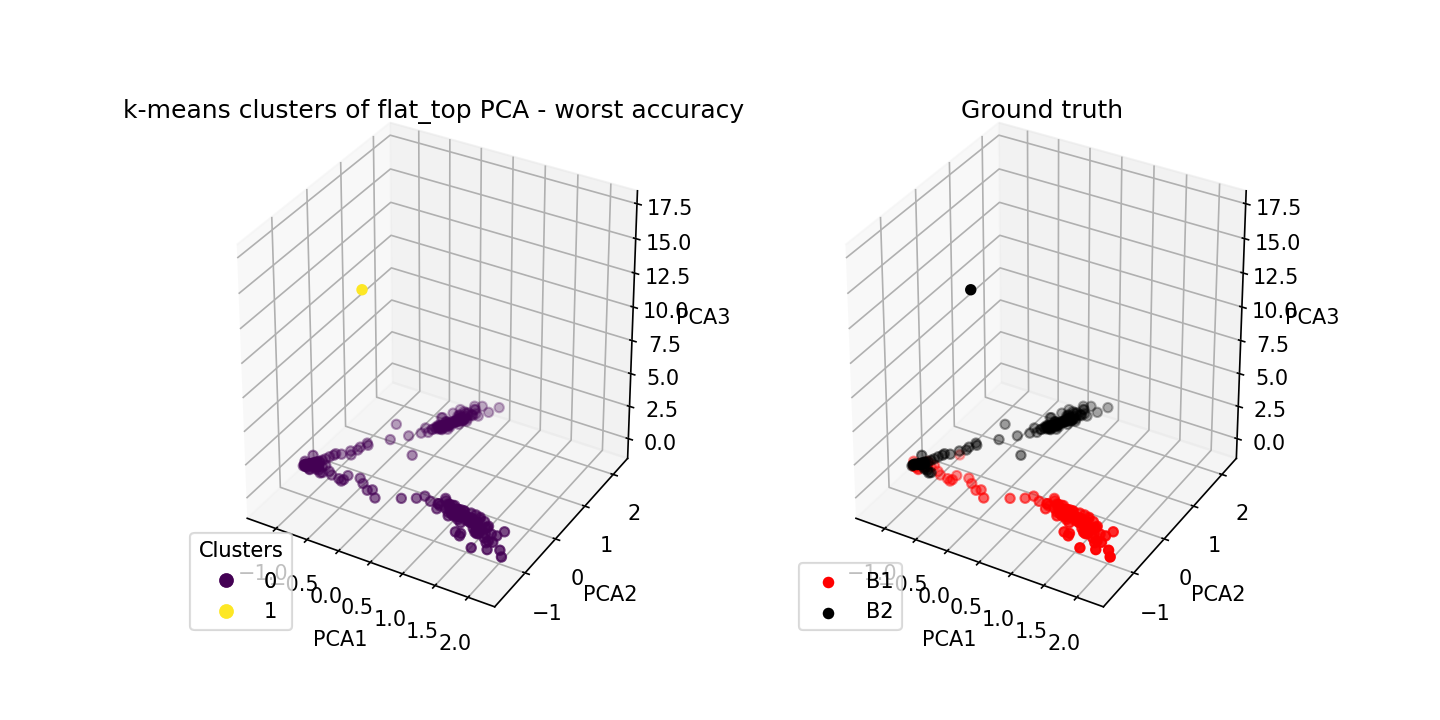

Best performing clustering result:
	Average accuracy = 85.78%
	Cluster 0 has 69.87% of the losses, of which:
			71.56% are B1, 	28.44% are B2

	Cluster 1 has 30.13% of the losses, of which:
			0.00% are B1, 	100.00% are B2



<IPython.core.display.Javascript object>


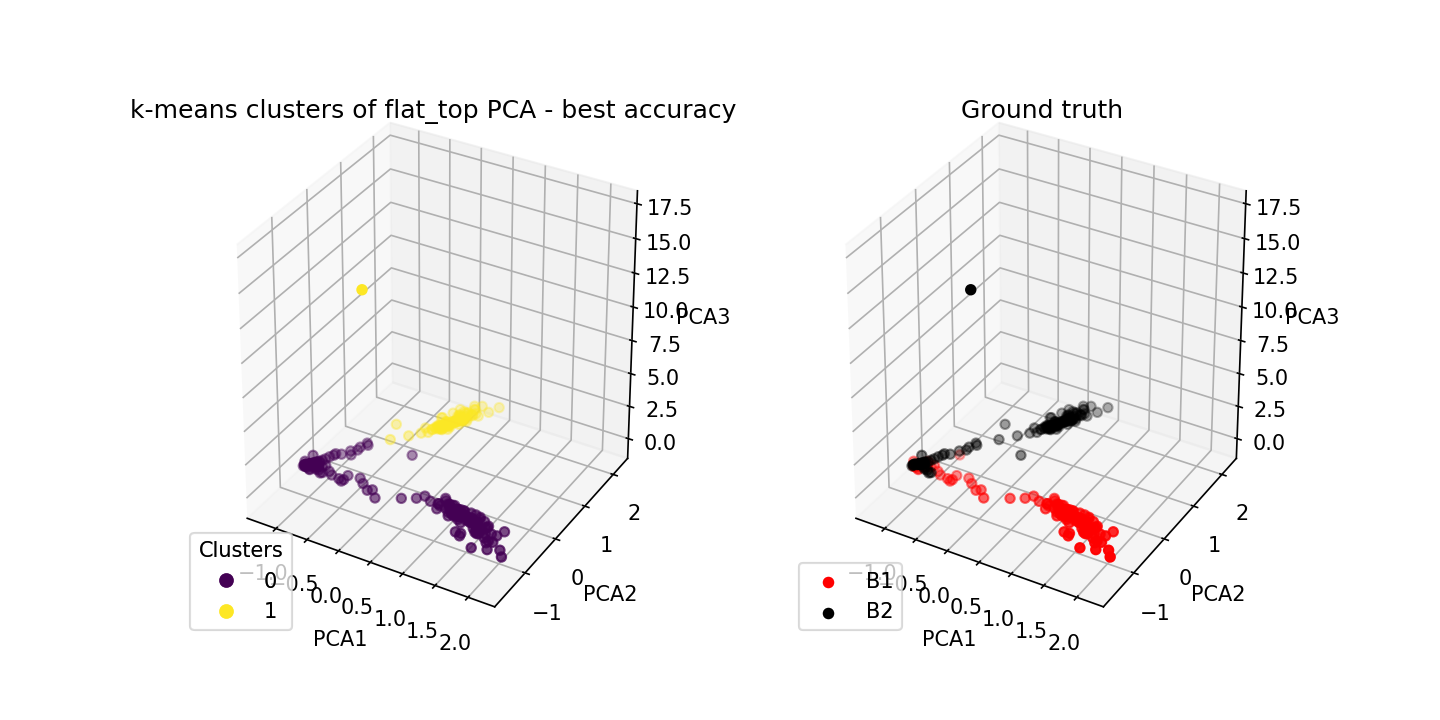

In [18]:
kmeansAnalysis(kmeans, flatTopLosses, "flat_top", runCount)
kmeansAnalysis(kmeans, flatTopLossesPCA, "flat_top PCA", runCount)

start_ramp

Accuracies std dev = 0.0
Accuracies mean = 0.5067798132183908

Worst performing clustering result:
	Average accuracy = 50.68%
	Cluster 0 has 42.38% of the losses, of which:
			49.22% are B1, 	50.78% are B2

	Cluster 1 has 57.62% of the losses, of which:
			50.57% are B1, 	49.43% are B2

Best performing clustering result:
	Average accuracy = 50.68%
	Cluster 0 has 42.38% of the losses, of which:
			49.22% are B1, 	50.78% are B2

	Cluster 1 has 57.62% of the losses, of which:
			50.57% are B1, 	49.43% are B2

start_ramp PCA

Accuracies std dev = 0.0
Accuracies mean = 0.792356047271813

Worst performing clustering result:
	Average accuracy = 79.24%
	Cluster 0 has 67.88% of the losses, of which:
			31.22% are B1, 	68.78% are B2

	Cluster 1 has 32.12% of the losses, of which:
			89.69% are B1, 	10.31% are B2



<IPython.core.display.Javascript object>


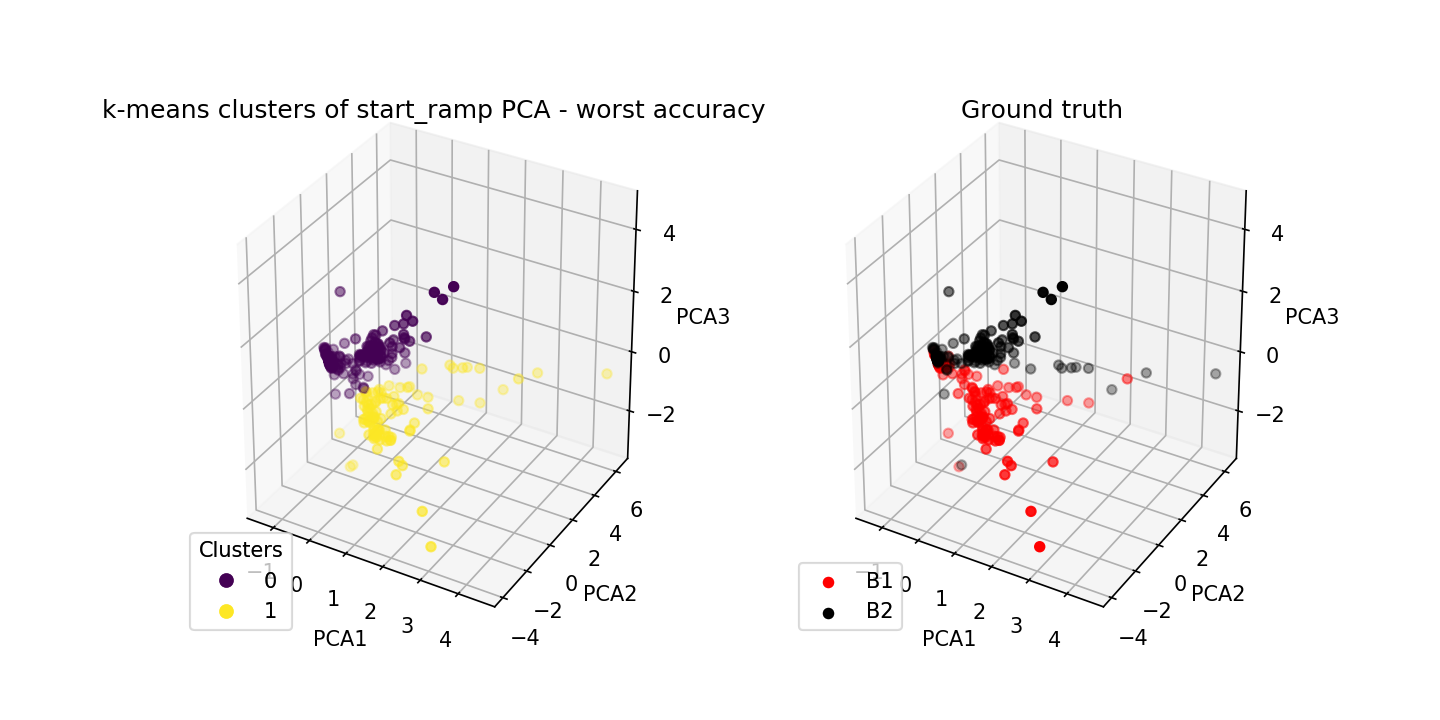

Best performing clustering result:
	Average accuracy = 79.24%
	Cluster 0 has 67.88% of the losses, of which:
			31.22% are B1, 	68.78% are B2

	Cluster 1 has 32.12% of the losses, of which:
			89.69% are B1, 	10.31% are B2



<IPython.core.display.Javascript object>


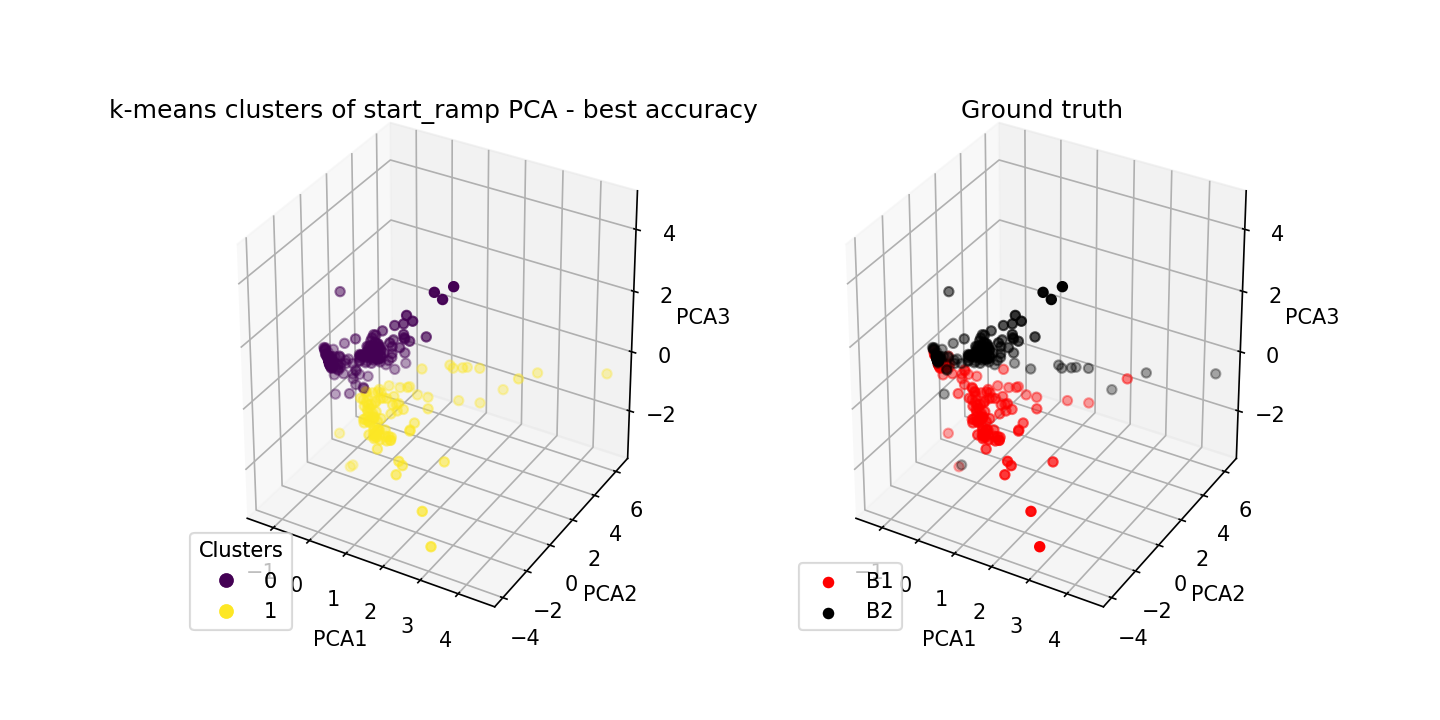

In [19]:
kmeansAnalysis(kmeans, startRampLosses, "start_ramp", runCount)
kmeansAnalysis(kmeans, startRampLossesPCA, "start_ramp PCA", runCount)

start_squeeze

Accuracies std dev = 0.0008708379571823871
Accuracies mean = 0.8968271072796935

Worst performing clustering result:
	Average accuracy = 89.66%
	Cluster 0 has 63.04% of the losses, of which:
			20.69% are B1, 	79.31% are B2

	Cluster 1 has 36.96% of the losses, of which:
			100.00% are B1, 	0.00% are B2

Best performing clustering result:
	Average accuracy = 89.93%
	Cluster 0 has 37.39% of the losses, of which:
			100.00% are B1, 	0.00% are B2

	Cluster 1 has 62.61% of the losses, of which:
			20.14% are B1, 	79.86% are B2

start_squeeze PCA

Accuracies std dev = 0.006098279177975158
Accuracies mean = 0.8983105109091244

Worst performing clustering result:
	Average accuracy = 88.95%
	Cluster 0 has 38.70% of the losses, of which:
			2.25% are B1, 	97.75% are B2

	Cluster 1 has 61.30% of the losses, of which:
			80.14% are B1, 	19.86% are B2



<IPython.core.display.Javascript object>


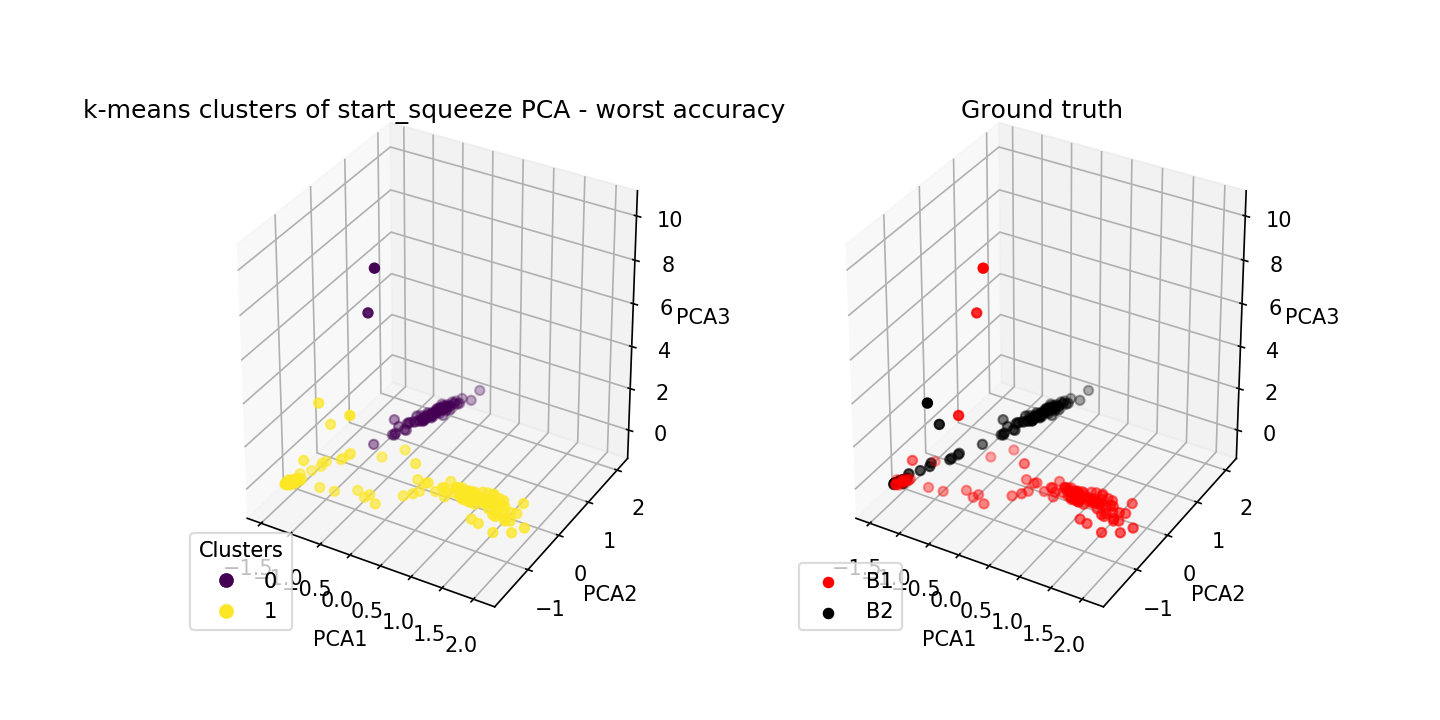

Best performing clustering result:
	Average accuracy = 90.21%
	Cluster 0 has 62.17% of the losses, of which:
			80.42% are B1, 	19.58% are B2

	Cluster 1 has 37.83% of the losses, of which:
			0.00% are B1, 	100.00% are B2



<IPython.core.display.Javascript object>


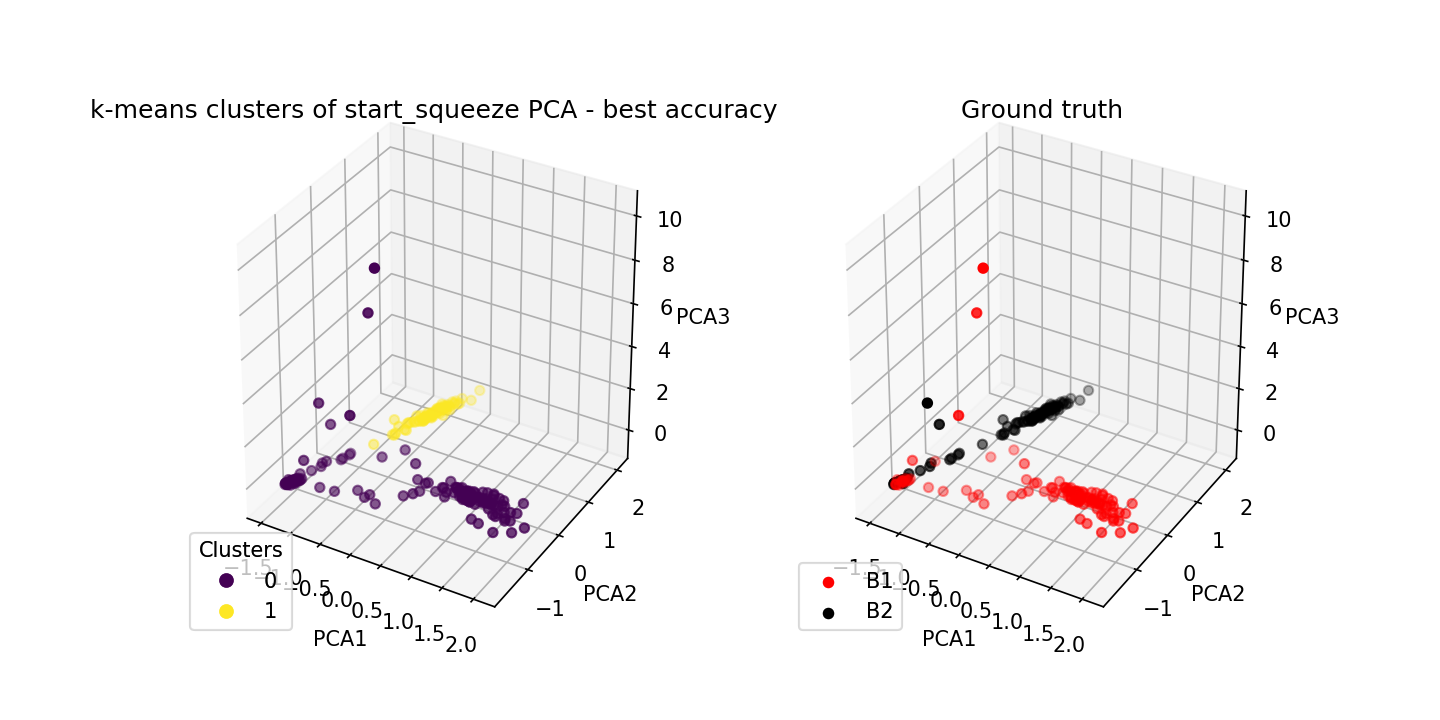

In [20]:
kmeansAnalysis(kmeans, startSqueezeLosses, "start_squeeze", runCount)
kmeansAnalysis(kmeans, startSqueezeLossesPCA, "start_squeeze PCA", runCount)

start_adjust

Accuracies std dev = 0.0
Accuracies mean = 0.50862316757689

Worst performing clustering result:
	Average accuracy = 50.86%
	Cluster 0 has 40.83% of the losses, of which:
			48.98% are B1, 	51.02% are B2

	Cluster 1 has 59.17% of the losses, of which:
			50.70% are B1, 	49.30% are B2

Best performing clustering result:
	Average accuracy = 50.86%
	Cluster 0 has 40.83% of the losses, of which:
			48.98% are B1, 	51.02% are B2

	Cluster 1 has 59.17% of the losses, of which:
			50.70% are B1, 	49.30% are B2

start_adjust PCA

Accuracies std dev = 0.0
Accuracies mean = 0.5085714285714286

Worst performing clustering result:
	Average accuracy = 50.86%
	Cluster 0 has 58.33% of the losses, of which:
			49.29% are B1, 	50.71% are B2

	Cluster 1 has 41.67% of the losses, of which:
			51.00% are B1, 	49.00% are B2



<IPython.core.display.Javascript object>


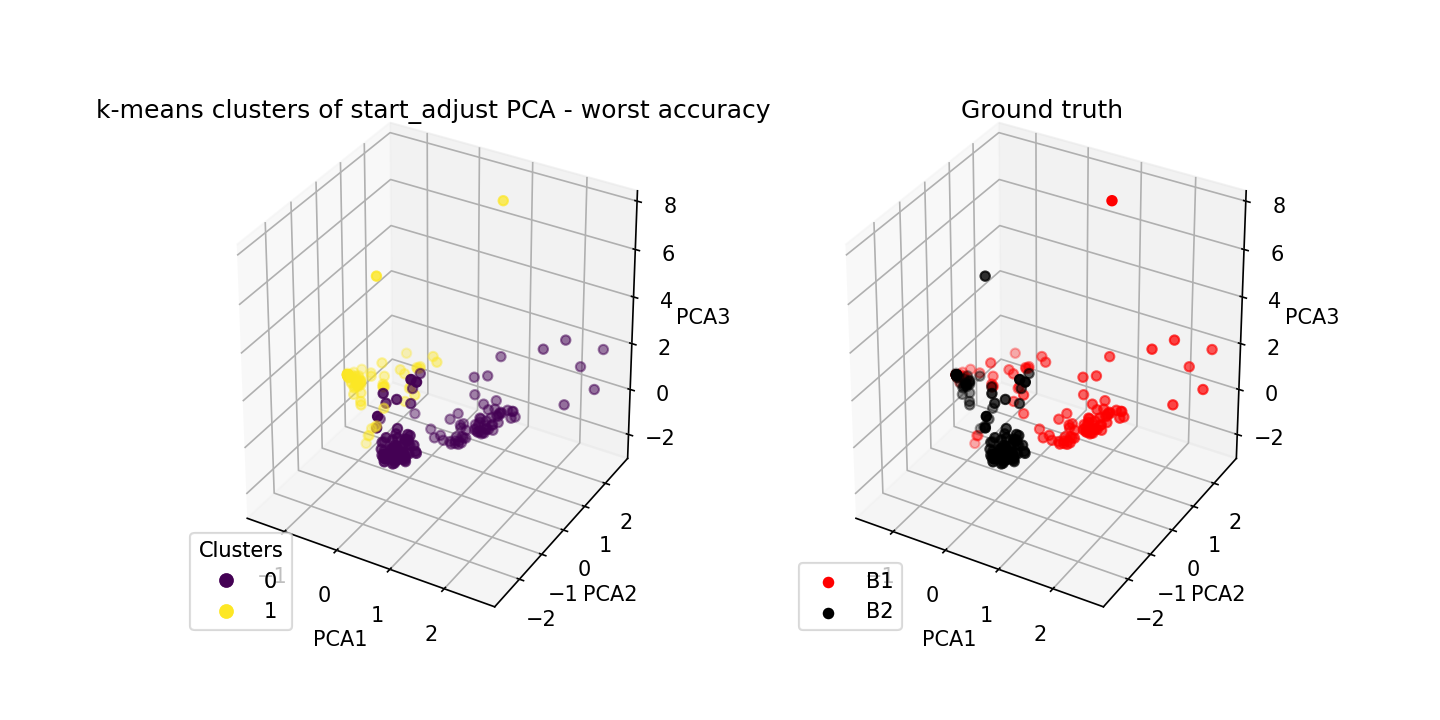

Best performing clustering result:
	Average accuracy = 50.86%
	Cluster 0 has 58.33% of the losses, of which:
			49.29% are B1, 	50.71% are B2

	Cluster 1 has 41.67% of the losses, of which:
			51.00% are B1, 	49.00% are B2



<IPython.core.display.Javascript object>


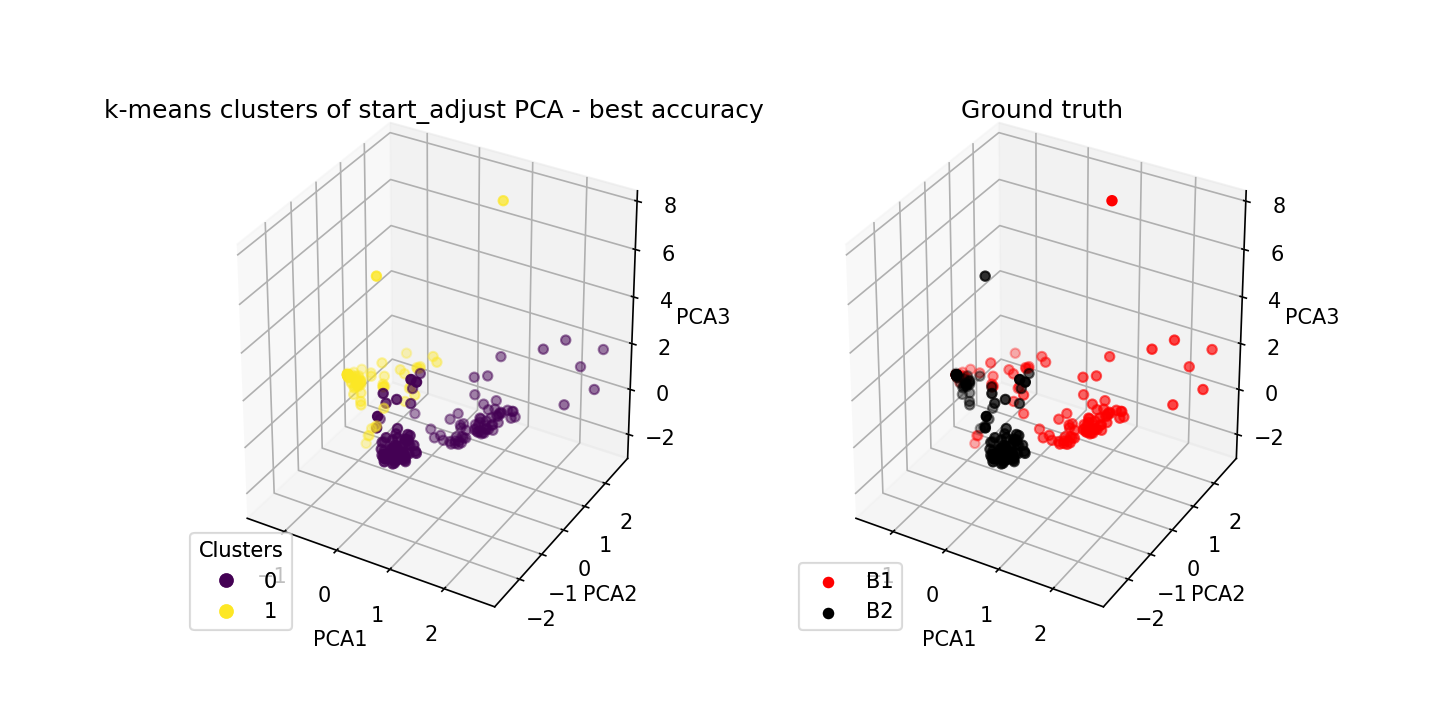

In [21]:
kmeansAnalysis(kmeans, startAdjustLosses, "start_adjust", runCount)
kmeansAnalysis(kmeans, startAdjustLossesPCA, "start_adjust PCA", runCount)

## DBSCAN



### Helper functions

In [22]:
def dbscanAnalysis(dbscan, lossesPCA, phaseName):
    labelsPCA = dbscan.fit_predict(lossesPCA)
    
    clusteringResult = ClusteringResult(labelsPCA)
    clusteringResult.describe()
    
    scatterPlotClusters(lossesPCA, f"DBSCAN clusters of {phaseName}", labelsPCA)

### Analysis

In [23]:
#TODO move imports to topmost cell?  eg. kmeans import is in topmost cell
from sklearn.cluster import DBSCAN
# eps - "The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not
#        a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose 
#        appropriately for your data set and distance function."
# min_samples - "The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
#                This includes the point itself."

# min samples: can go from 5% of the data set size up to 30%.  
# don't forget this is a MINIMUM. it's not THE number of points in each cluster
# -- Do a loop, try out differnt vslues of min neighbours

# eps: after doing scaling, print out the max and min in the dataframe.  
#     will give indication of eps.  or choose eps to match ground truth.
# ? what is eps ground truth?

dbscan = DBSCAN(eps=0.5, min_samples=15) # these params worked when PCA whiten=True
                                        # if whiten=False, try eps=1, min_samples=6 and eps=1.4, min=15 - 5% of startRamp len
                                        # looks like if min_samples goes up, eps must also ... otherwise we are expecting
        # a very dense neighbourhood for a point to be a core point if we have a small eps (radius) and a high min_samples.
        # eg. eps=0.3, min_samples=6 worked (PCA whiten=True).  but boosting min_samples to 15, I also boosted eps to 0.5
        # and this gave me the "nicest" result yet
# from Wikipedia = as a rule of thumb, 2*dimensions (2*3 = 6) can be used

does dbscan tell you that there are multiple classes?  two classes?  1 class?

	Average accuracy = 75.29%
	Cluster -1 has 19.21% of the losses, of which:
			41.38% are B1, 	58.62% are B2

	Cluster 0 has 23.18% of the losses, of which:
			100.00% are B1, 	0.00% are B2

	Cluster 1 has 57.62% of the losses, of which:
			32.76% are B1, 	67.24% are B2



<IPython.core.display.Javascript object>


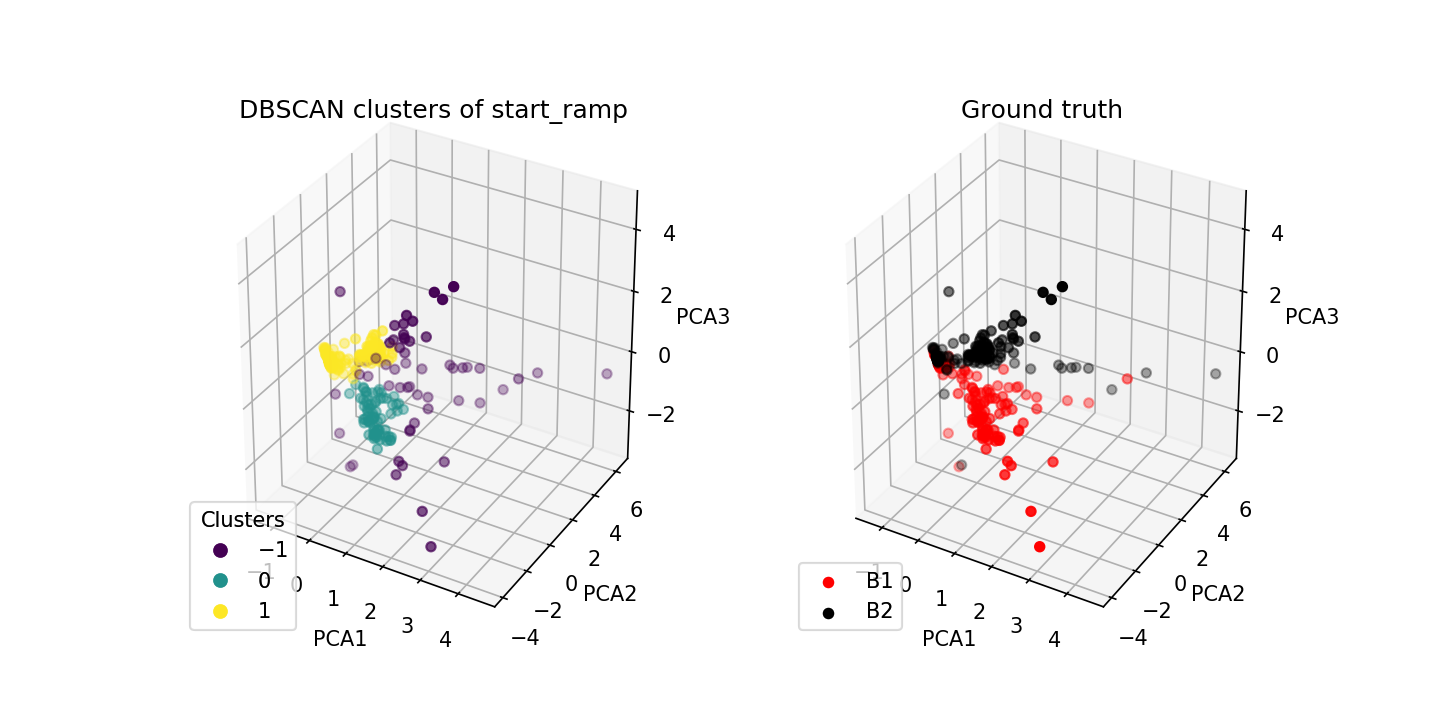

In [24]:
dbscanAnalysis(dbscan, startRampLossesPCA, "start_ramp")

	Average accuracy = 75.21%
	Cluster -1 has 24.58% of the losses, of which:
			49.15% are B1, 	50.85% are B2

	Cluster 0 has 26.67% of the losses, of which:
			50.00% are B1, 	50.00% are B2

	Cluster 1 has 24.58% of the losses, of which:
			100.00% are B1, 	0.00% are B2

	Cluster 2 has 24.17% of the losses, of which:
			0.00% are B1, 	100.00% are B2



<IPython.core.display.Javascript object>


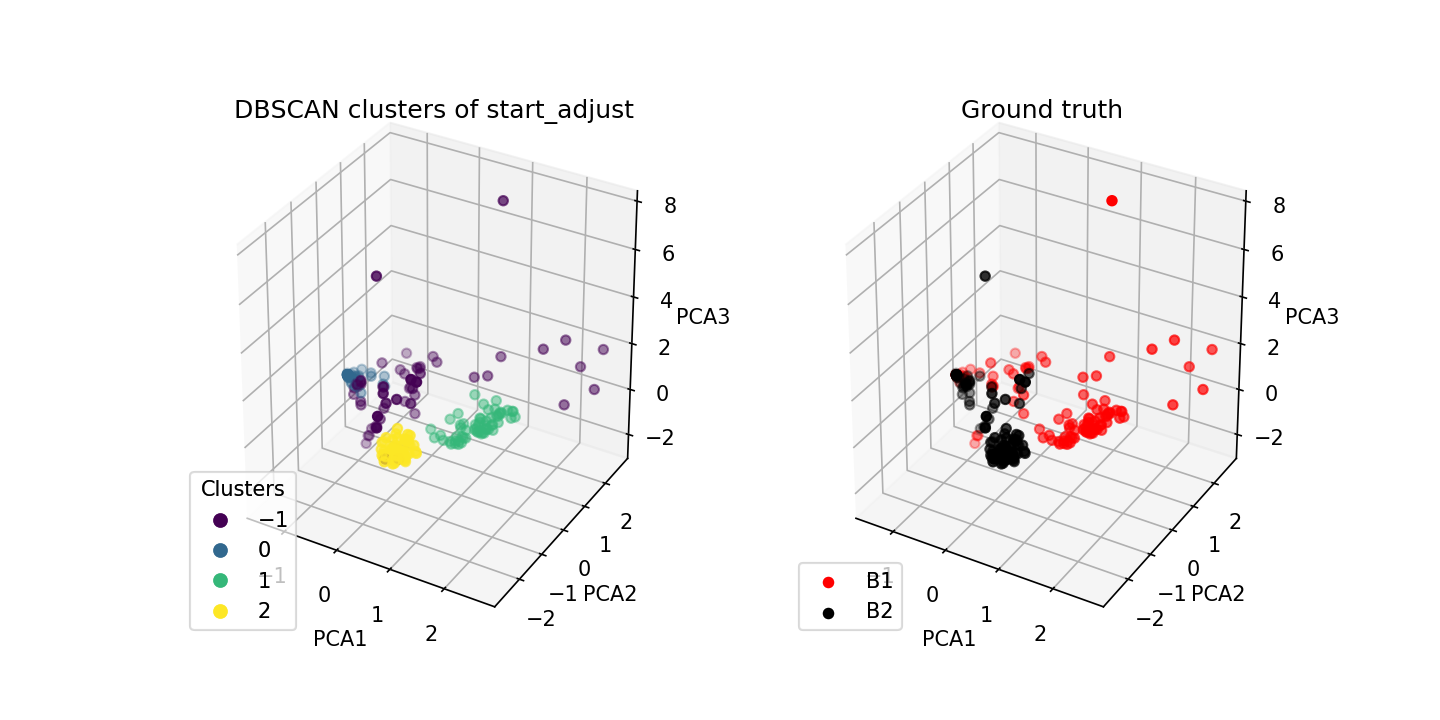

In [25]:
dbscanAnalysis(dbscan, startAdjustLossesPCA, "start_adjust")

	Average accuracy = 78.88%
	Cluster -1 has 8.26% of the losses, of which:
			63.16% are B1, 	36.84% are B2

	Cluster 0 has 36.09% of the losses, of which:
			100.00% are B1, 	0.00% are B2

	Cluster 1 has 18.26% of the losses, of which:
			47.62% are B1, 	52.38% are B2

	Cluster 2 has 37.39% of the losses, of which:
			0.00% are B1, 	100.00% are B2



<IPython.core.display.Javascript object>


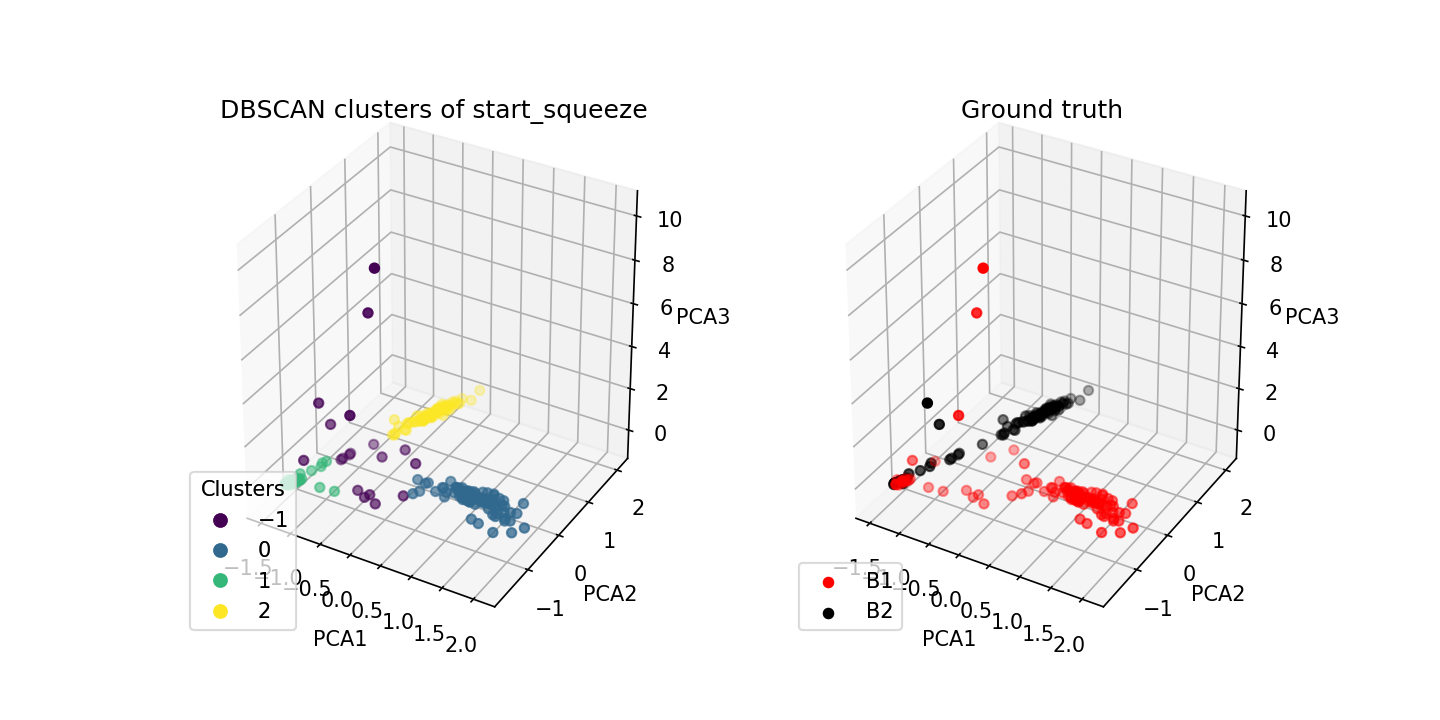

In [26]:
dbscanAnalysis(dbscan, startSqueezeLossesPCA, "start_squeeze")

	Average accuracy = 82.71%
	Cluster -1 has 1.66% of the losses, of which:
			20.00% are B1, 	80.00% are B2

	Cluster 0 has 29.80% of the losses, of which:
			100.00% are B1, 	0.00% are B2

	Cluster 1 has 39.07% of the losses, of which:
			50.85% are B1, 	49.15% are B2

	Cluster 2 has 29.47% of the losses, of which:
			0.00% are B1, 	100.00% are B2



<IPython.core.display.Javascript object>


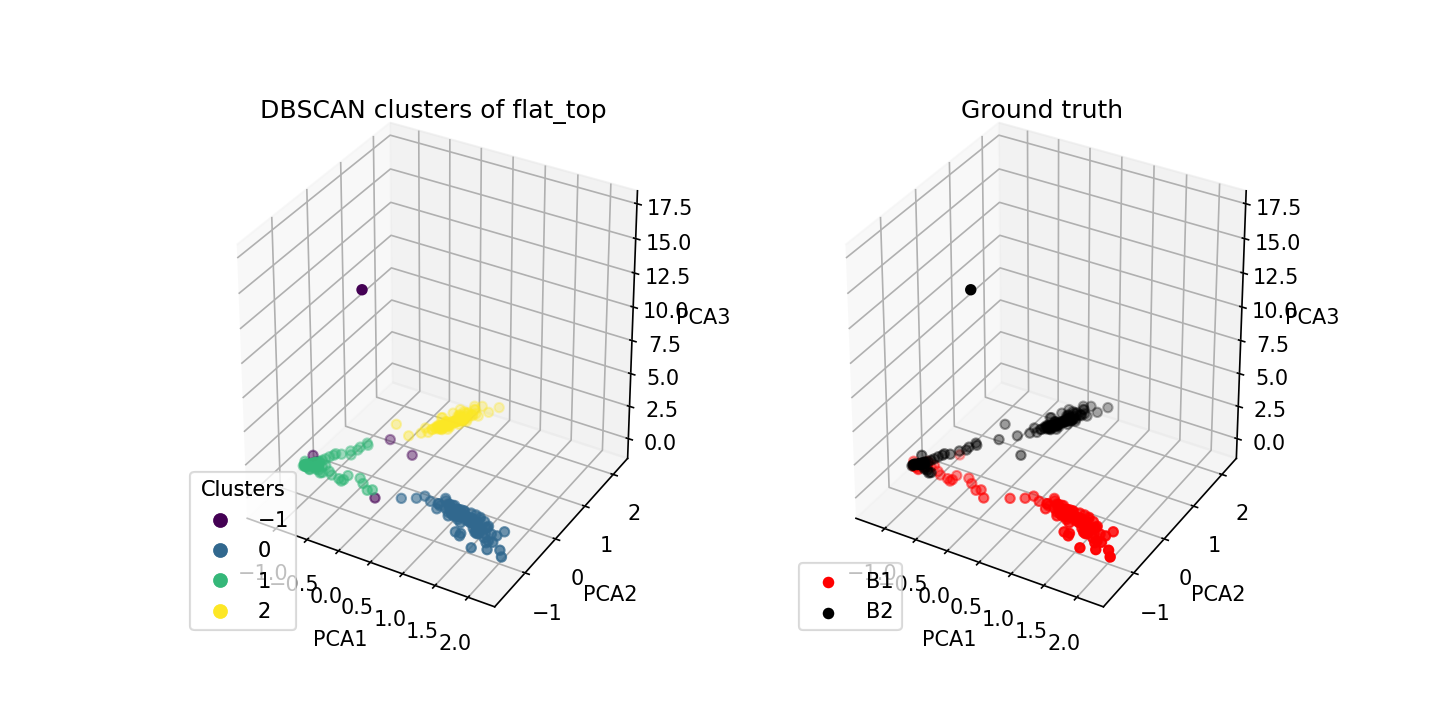

In [27]:
dbscanAnalysis(dbscan, flatTopLossesPCA, "flat_top")

## Euclidean distance

### Helper functions

To get Euclidean distance between the BLM vectors for beam 1 and beam 2

In [28]:
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean

def getEuclideanDistance(losses):
    return pd.Series(cdist(losses.loc['B1'].values, losses.loc['B2'].values, metric='euclidean').diagonal(),
                     index=losses.loc['B1'].index) # to preserve the fill numbers for x-axis of the euclidean distance plot

# getting diagonal to get the euclidean distance of pairs of vectors we care about (i.e. corresponding rows)
# ie. euclidean distance between row 0 of B1 values, row 0 of B2 values; euclidean distance between row 1 of B1 values,
# row 1 of B2 values, and so on.

# to confirm values are correct:
# print(distance)
# print(euclidean(mergedPhaseLosses.loc['B1'].iloc[0], mergedPhaseLosses.loc['B2'].iloc[0]))
# print(euclidean(mergedPhaseLosses.loc['B1'].iloc[1], mergedPhaseLosses.loc['B2'].iloc[1]))
# ...

### Analysis

<IPython.core.display.Javascript object>


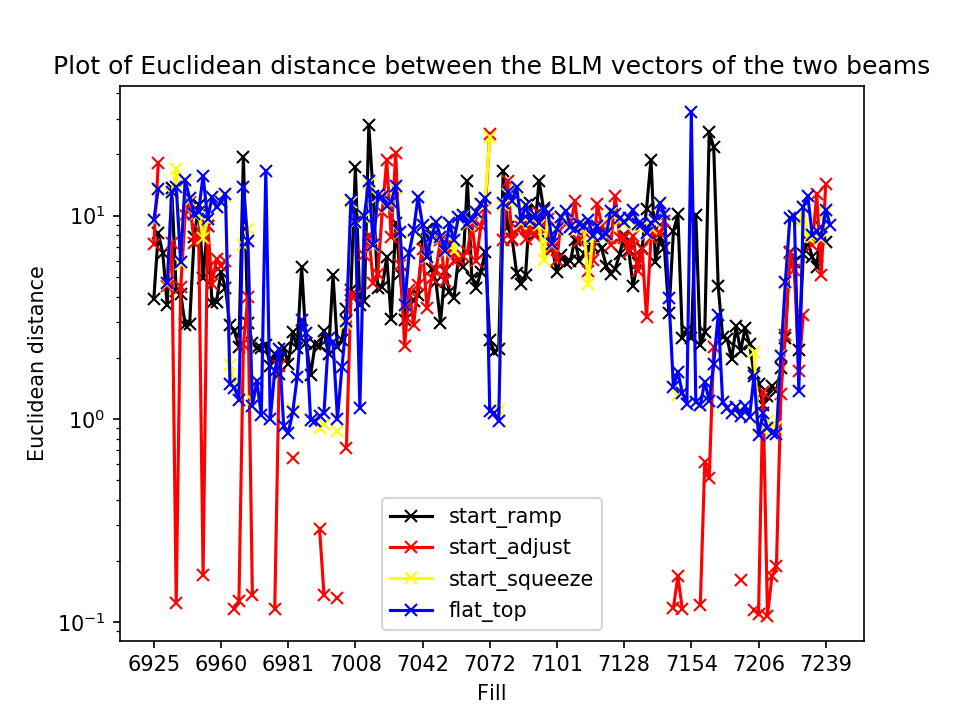

In [29]:
df = pd.DataFrame({
    'start_ramp': getEuclideanDistance(startRampLosses),
    'start_adjust': getEuclideanDistance(startAdjustLosses),
    'start_squeeze': getEuclideanDistance(startSqueezeLosses),
    'flat_top': getEuclideanDistance(flatTopLosses)
})

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.plot('start_ramp', data=df, marker='x', color='black')
ax.plot('start_adjust', data=df, marker='x', color='red')
ax.plot('start_squeeze', data=df, marker='x', color='yellow')
ax.plot('flat_top', data=df, marker='x', color='blue')
ax.set(xlabel='Fill',
       ylabel='Euclidean distance',
       title='Plot of Euclidean distance between the BLM vectors of the two beams')
ax.legend()
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=15.0))  # set freqeuency of x-axis labels (fill numbers)

# TODO repeat for PCA

## Linear classifier

Here we deliberately use linear classifiers because we are interested in finding asymmetry if it exists.  The worse the classifier does at linearly separating the data, the more symmetric the data.  The better the classisfier does at linearly separating the data, the more asymmetric the data.

### Helper functions

In [30]:
def plotClassifierPlane(lossesPCA, phaseName, clf):
    # Note: https://matplotlib.org/mpl_toolkits/mplot3d/faq.html#my-3d-plot-doesn-t-look-right-at-certain-viewing-angles
    #"This is probably the most commonly reported issue with mplot3d. The problem is that – from some viewing angles – a 
    #3D object would appear in front of another object, even though it is physically behind it."

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatterPlotLosses(lossesPCA, f"Linear SVC decision plane on {phaseName}", ax)
    
    # ax.plot_surface([0,0], [1,1], [1,1])
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
#     zlim = ax.get_zlim() - for having same scale on axes as original plot (before adding the surface)
    x, y = np.meshgrid(np.linspace(xlim[0], xlim[1], 2),
                         np.linspace(ylim[0], ylim[1], 2))
    z = lambda x, y: (-clf.intercept_[0]-clf.coef_[0][0]*x-clf.coef_[0][1]*y) / clf.coef_[0][2]
    
#     ax.set_zlim(zlim) - for having same scale on axes as original plot (before adding the surface)
    ax.plot_surface(x, y, z(x,y), alpha=0.9)

In [31]:
def linearClassifierAnalysis(clf, lossesPCA, phaseName):
    samplesCount = len(lossesPCA)
    
    # make ground truth labels used by the linear classifier - where each element of the list corresponds to a row
    #     1 means the corresponding row is a B1 loss
    #     2 means the corresponding row is a B2 loss
    classes = ([1] * (samplesCount // 2)) + ([2] * (samplesCount // 2))

    # test that class 1 corresponds to 'B1' index in the dataframe, class 2 corresponds to 'B2'
    for idx, c in enumerate(classes):
        assert (c == 1 and lossesPCA.iloc[idx].name[0] == 'B1') or (c == 2 and lossesPCA.iloc[idx].name[0] == 'B2')

    clf.fit(lossesPCA, classes)
#     print(clf.predict(lossesPCA))

    result = ClusteringResult(clf.predict(lossesPCA))
    result.describe()
#     print(clf.score(lossesPCA, classes)) # also gives accuracy.  TODO ask - numbers are slightly different.  due to floats?
    plotClassifierPlane(lossesPCA, phaseName, clf)

### Analysis

In [32]:
from sklearn import svm
clf = svm.LinearSVC(dual=False) # docs: "Prefer dual=False when n_samples > n_features"
#TODO ask - should you standardise before SVM?
#I think so: https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf
#A Practical Guide to Support Vector CLassification: The main advantage of scaling is to avoid attributes in greater numeric
#ranges dominating those in smaller numeric ranges. Another advantage is to avoid numerical diculties during the calculation. 
#Because kernel values usually depend on the inner products of feature vectors, e.g. the linear kernel and the polynomial 
#ker- nel, large attribute values might cause numerical problems. We recommend linearly scaling each attribute to the range 
#[-1,+1] or [0,1].
# TODO ask about this - the authors are recommending to scale linearly but I have standardised (i.e. changing the distribution
# to unit variance, zero mean.)

	Average accuracy = 90.07%
	Cluster 1 has 57.50% of the losses, of which:
			84.06% are B1, 	15.94% are B2

	Cluster 2 has 42.50% of the losses, of which:
			3.92% are B1, 	96.08% are B2



<IPython.core.display.Javascript object>


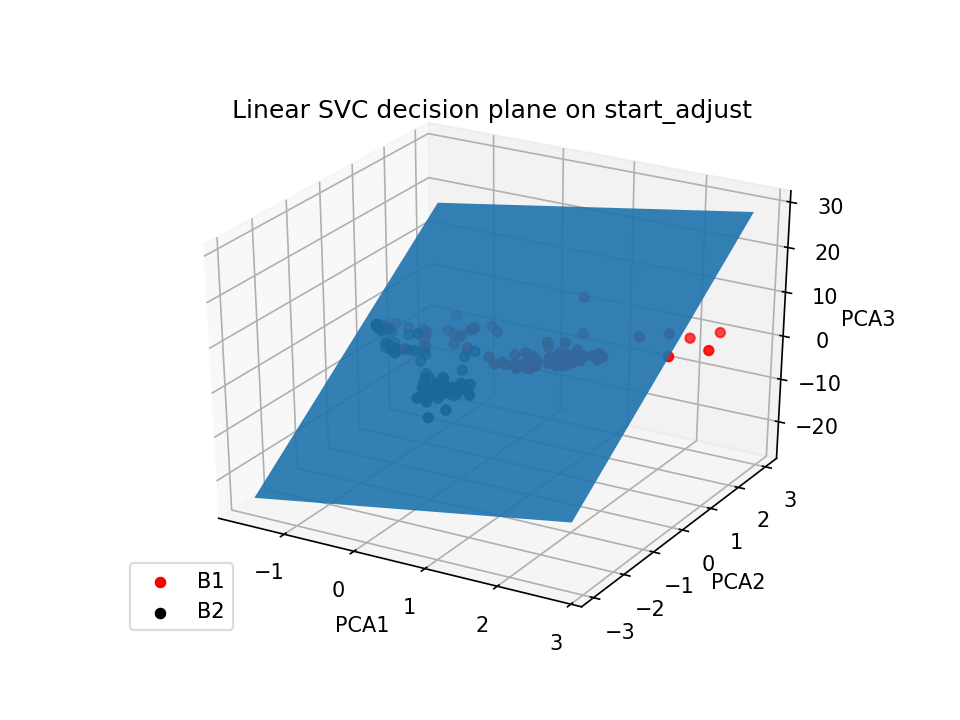

In [33]:
linearClassifierAnalysis(clf, startAdjustLossesPCA, 'start_adjust')

	Average accuracy = 90.52%
	Cluster 1 has 44.70% of the losses, of which:
			94.81% are B1, 	5.19% are B2

	Cluster 2 has 55.30% of the losses, of which:
			13.77% are B1, 	86.23% are B2



<IPython.core.display.Javascript object>


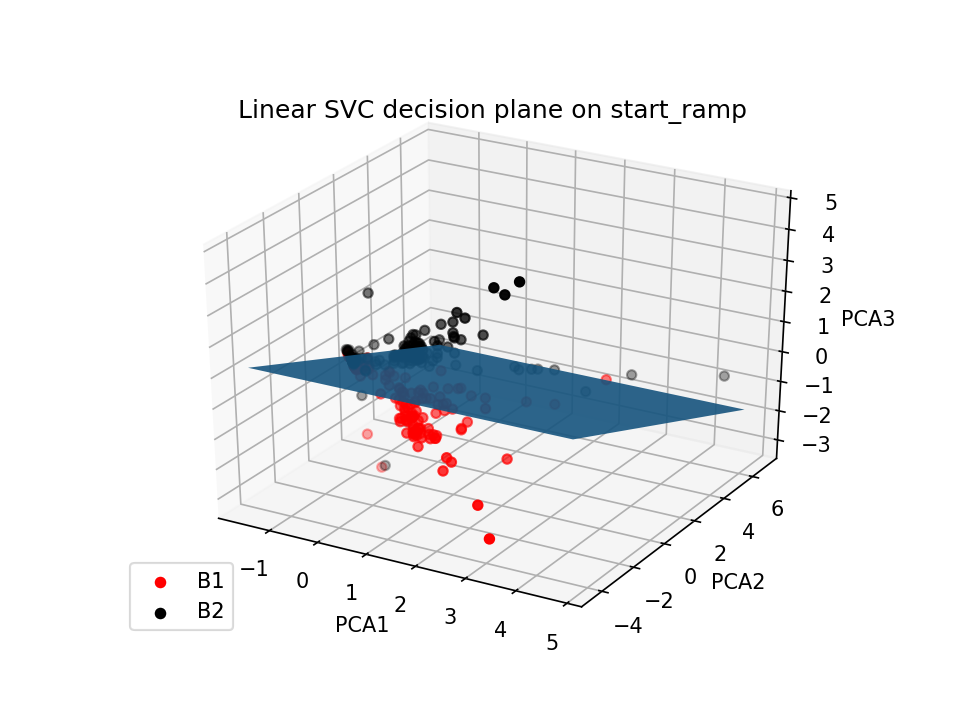

In [34]:
linearClassifierAnalysis(clf, startRampLossesPCA, 'start_ramp')

	Average accuracy = 93.16%
	Cluster 1 has 44.35% of the losses, of which:
			98.04% are B1, 	1.96% are B2

	Cluster 2 has 55.65% of the losses, of which:
			11.72% are B1, 	88.28% are B2



<IPython.core.display.Javascript object>


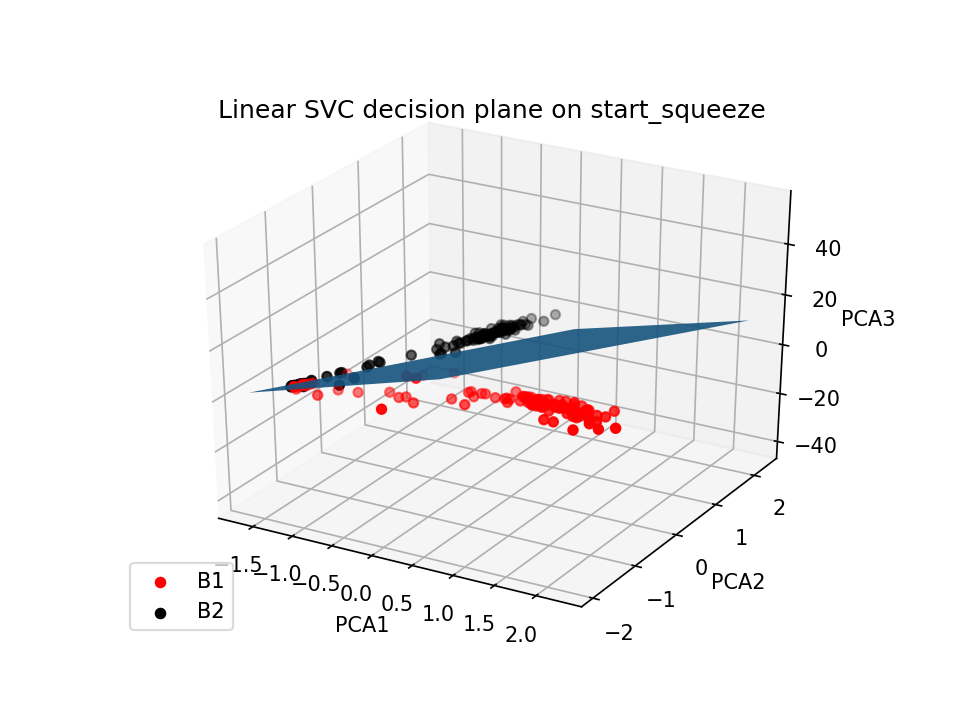

In [35]:
linearClassifierAnalysis(clf, startSqueezeLossesPCA, 'start_squeeze')

	Average accuracy = 95.40%
	Cluster 1 has 48.68% of the losses, of which:
			96.60% are B1, 	3.40% are B2

	Cluster 2 has 51.32% of the losses, of which:
			5.81% are B1, 	94.19% are B2



C:\Users\mvell\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


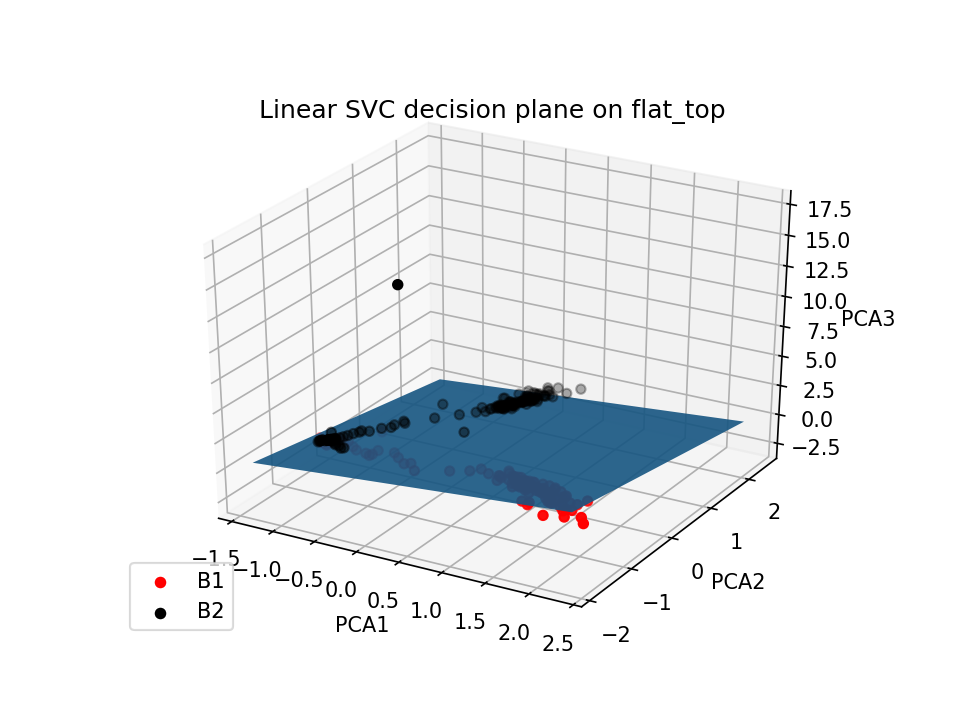

In [36]:
linearClassifierAnalysis(clf, flatTopLossesPCA, 'flat_top')

## Exploratory plots

C:\Users\mvell\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


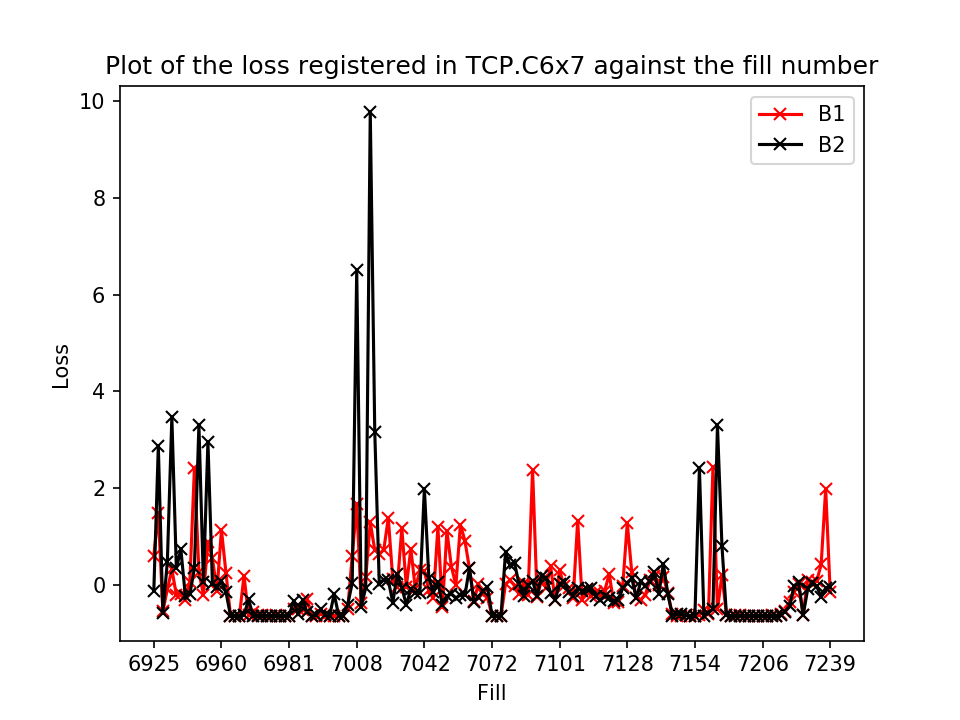

In [37]:
# Data
df = pd.DataFrame({
    'B1': startRampLosses.loc['B1']['TCP.C6x7'],
    'B2': startRampLosses.loc['B2']['TCP.C6x7']
})
 
# multiple line plot
fig, ax = plt.subplots()
ax.plot('B1', data=df, marker='x', color='red')
ax.plot('B2', data=df, marker='x', color='black')
ax.set(xlabel='Fill', ylabel='Loss', title='Plot of the loss registered in TCP.C6x7 against the fill number')
ax.legend()
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=15.0))  # set freqeuency of x-axis labels (fill numbers)

In [38]:
# plt.figure(figsize=(10, 36))
# ncols = 3;
# nrows = math.ceil(startRampLosses.shape[1] / ncols)
# i = 1;
# for column in startRampLosses:
#     # Data
#     df = pd.DataFrame({
#         'B1': startRampLosses.loc['B1'][column],
#         'B2': startRampLosses.loc['B2'][column]
#     })
 
#     plt.subplot(nrows, ncols, i)
# #     plt.yscale('log') # TODO - ask: no need for log scale since we have standardised the data now?
# #     plt.yscale('symlog') - since we have negative values now after standardising
#     plt.plot('B1', data=df, marker='x', color='red')
#     plt.plot('B2', data=df, marker='x', color='black')
#     plt.title(column)

    
#     i = i + 1
    

# plt.tight_layout()